# seq2seq模型——机器翻译

进阶改进：

1. 使用词替换字
2. 引入Attention机制

引入依赖包

In [1]:
import unicodedata
import string
import re
import random
import time
import math

import jieba
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torchtext.data.metrics import bleu_score

如果使用GPU，则将下面的变量设为`True`。

In [2]:
print('CUDA available: %s' % torch.cuda.is_available())

CUDA available: True


In [3]:
USE_CUDA = torch.cuda.is_available()

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
print('Device: %s' % device)

Device: cuda


# 读取数据

我们将读取目录下的`cn-eng.txt`文件，其中每一行是一个平行句对，例子如下：

```
我很冷。    I am cold.
```

## 对于单词进行编号

这里引入了两个特殊符号，“SOS”即“Start of sentence”和“EOS”即“End of sentence”。他们会加到输入文本的两端，以控制解码过程。

In [6]:
SOS_token = 0
EOS_token = 1

class Lang(object):
    """
    词表Vocabulary.
    """

    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2 # Count SOS and EOS
      
    def index_words(self, sentence):
        if self.name == 'cn':
            # 使用jieba分词
            for word in jieba.cut(sentence):
                self.index_word(word)
        else:
            for word in sentence.split(' '):
                self.index_word(word)

    def index_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

## 文本预处理

丢弃除了中文、字母和常用标点之外的符号。

In [7]:
# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalize_string(s):
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z\u4e00-\u9fa5.!?，。？]+", r" ", s)
    return s

读取平行语料，并进行清理。

In [8]:
def read_langs(lang1, lang2, reverse=False):
    """
    读取语料数据.
    :return (输入词表，输出词表，平行语料对)
    """
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('%s-%s.txt' % (lang1, lang2)).read().strip().split('\n')
    
    # Split every line into pairs and normalize
    pairs = [[normalize_string(s) for s in l.split('\t')] for l in lines]
    
    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
        
    return input_lang, output_lang, pairs

## 过滤句子

样例为了加快训练，只保留了不长于10个单词的句对，真正实验中将更多数据考虑进来可能获得更好的效果。

In [9]:
MAX_LENGTH = 10

def filter_pair(p):
    return len(p[1].split(' ')) < MAX_LENGTH

def filter_pairs(pairs):
    return [pair for pair in pairs if filter_pair(pair)]

处理数据的全过程：

- 读取数据，每一行分别处理，将其转换成句对
- 对于文本进行处理，过滤无用符号
- 根据已有文本对于单词进行编号，构建符号到编号的映射


In [10]:
def prepare_data(lang1_name, lang2_name, reverse=False):
    input_lang, output_lang, pairs = read_langs(lang1_name, lang2_name, reverse)
    print("Read %s sentence pairs" % len(pairs))
    
    pairs = filter_pairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    
    print("Indexing words...")
    for pair in pairs:
        input_lang.index_words(pair[0])
        output_lang.index_words(pair[1])

    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepare_data('cn', 'eng', False)

# Print an example pair
print(random.choice(pairs))

Reading lines...


Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache


Read 90000 sentence pairs
Trimmed to 68898 sentence pairs
Indexing words...


Loading model cost 0.437 seconds.
Prefix dict has been built succesfully.


['请找到问题的解决方法。', 'please find a solution to the problem .']


## 将文本数据转换为张量

为了训练，我们需要将句子变成神经网络可以理解的东西（数字）。每个句子将被分解成单词，然后变成张量，其中每个单词都被索引替换（来自之前的Lang索引）。在创建这些张量时，我们还将附加EOS令牌以表示该句子已结束。

![](https://i.imgur.com/LzocpGH.png)

In [11]:
# Return a list of indexes, one for each word in the sentence
def indexes_from_sentence(lang, sentence):
    """
    根据词表，将句子转化成索引列表。

    :reutrn list，e.g. [1, 2, 3, 4]
    """
    if lang.name == 'cn':
        return [lang.word2index[word] for word in jieba.cut(sentence)]
    else:
        return [lang.word2index[word] for word in sentence.split(' ')]

def variable_from_sentence(lang, sentence):
    """
    将句子转换成Tensor.
    
    :return Tensor, shape(n, 1)
    """
    indexes = indexes_from_sentence(lang, sentence)
    indexes.append(EOS_token)
    var = torch.LongTensor(indexes).view(-1, 1)
    if USE_CUDA: var = var.cuda()
    return var

def variables_from_pair(pair):
    """
    将平行语料对转化成Tensors.
    
    :return (input_tensor, output_tensor)
    """
    input_variable = variable_from_sentence(input_lang, pair[0])
    target_variable = variable_from_sentence(output_lang, pair[1])
    return (input_variable, target_variable)

In [12]:
pair = random.choice(pairs)
print('pair: %s' % pair)

input_tensor, target_tensor = variables_from_pair(pair)
print('input_tensor shape: %s, output_tensor shap: %s' % (input_tensor.shape, target_tensor.shape))
print('input_tensor: %s' % input_tensor)

pair: ['汤姆昨天用刀切到自己了。', 'tom cut himself with his knife yesterday .']
input_tensor shape: torch.Size([9, 1]), output_tensor shap: torch.Size([9, 1])
input_tensor: tensor([[ 4932],
        [ 1084],
        [  427],
        [11715],
        [  417],
        [  770],
        [   10],
        [   11],
        [    1]], device='cuda:0')


# 模型

## 编码器

In [13]:
class EncoderGRU(nn.Module):
    """GRU 编码器"""

    def __init__(self, input_size, hidden_size, n_layers=1, bidirectional=False):
        """
        初始化
        :param input_size, 输入词表大
        :param hidden_size, Embedding维度大小，RNN hidden大小
        :param n_layers, RNN层数
        """
        super(EncoderGRU, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.bidirectional = bidirectional
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        
        # 用GRU替换RNN
        # self.rnn = nn.RNN(hidden_size, hidden_size, n_layers)
        self.rnn = nn.GRU(hidden_size, hidden_size, n_layers)
        
    def forward(self, word_inputs, hidden):
        """
        前向传播
        :param word_inputs, 输入序列 shape(n, 1)
        :param hidden, 隐层 shape(seq_len*n_layers, batch_size, hidden_size)
        :return output(seq_len, batch, num_directions*hidden_size),
                hidden(num_layers*num_directions, hidden_size)
        """
        # Note: we run this all at once (over the whole input sequence)
        seq_len = len(word_inputs)
        embedded = self.embedding(word_inputs).view(seq_len, 1, -1)
        output, hidden = self.rnn(embedded, hidden)
        return output, hidden

    def init_hidden(self):
        num_directions = 2 if self.bidirectional else 1
        hidden = torch.zeros(self.n_layers*num_directions, 1, self.hidden_size)
        if USE_CUDA: hidden = hidden.cuda()
        return hidden

In [14]:
encoder = EncoderGRU(input_lang.n_words, 100)
encoder.to(device)

pair = random.choice(pairs)
print('pair: %s' % pair)

encoder_hidden = encoder.init_hidden()
encoder_outputs, encoder_hidden = encoder(variable_from_sentence(input_lang, pair[0]), encoder_hidden)
print('seq_len: %s, encoder_outputs shape: %s, encoder_hidden shape: %s' % (
    len(pair[0]), encoder_outputs.shape, encoder_hidden.shape))

pair: ['在你面前是什麼東西？', 'what s in front of you ?']
seq_len: 10, encoder_outputs shape: torch.Size([8, 1, 100]), encoder_hidden shape: torch.Size([1, 1, 100])


## 注意力机制

In [15]:
class Attention(nn.Module):
    """意力机制"""
    
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size

        
    def forward(self, decoder_hidden, encoder_outputs):
        """
        前向传播
        :param decoder_hidden: shape(num_layers*num_directions, batch, hidden_size)
        :param encoder_outputs: shape(seq_len, batch, num_directions*hidden_size)
        :return attention_weighted_encoder_output shape(num_layers, batch, hidden_size)
        """
        attn_weights = F.softmax(torch.matmul(torch.squeeze(encoder_outputs), 
                                              torch.squeeze(decoder_hidden).view(-1, 1)))
        attn_weights = attn_weights.expand(encoder_outputs.shape[0], -1)
        attn_output = torch.sum(attn_weights * torch.squeeze(encoder_outputs), dim=0)
        return attn_output.view(1, 1, -1)
        


In [16]:
# attention = Attention(100)

# decoder_hidden = torch.randn(1, 1, 100)
# encoder_outputs = torch.randn(6, 1, 100)
# attention(decoder_hidden, encoder_outputs).shape

## 解码器

In [17]:
class DecoderGRU(nn.Module):
    """注意力机制解码器"""

    def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=0.1):
        super(DecoderGRU, self).__init__()
        
        # Keep parameters for reference
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.attention = Attention(hidden_size)
        
        # Define layers
        self.embedding = nn.Embedding(output_size, hidden_size)

        # 使用GRU替换RNN
        # self.rnn = nn.RNN(hidden_size, hidden_size, n_layers, dropout=dropout_p)
        self.rnn = nn.GRU(hidden_size, hidden_size, n_layers, dropout=dropout_p)
        self.out = nn.Linear(hidden_size*2, output_size)
    
    def forward(self, word_input, last_hidden, encoder_outputs):
        # Note: we run this one step at a time        
        word_embedded = self.embedding(word_input).view(1, 1, -1) # S=1 x B x N
        
        rnn_output, hidden = self.rnn(word_embedded, last_hidden)
        rnn_output = rnn_output.squeeze(0)

        # attention weighted encoder output
        attn_weighted_encoder_output = self.attention(hidden, encoder_outputs)
        attn_weighted_encoder_output = attn_weighted_encoder_output.squeeze(0)
        
        concat_output = torch.cat([rnn_output, attn_weighted_encoder_output], dim=1)
        output = F.log_softmax(self.out(concat_output))

        return output, hidden

In [18]:
decoder = DecoderGRU(100, output_lang.n_words)
decoder.to(device)

decoder_hidden = encoder_hidden.view(1, 1, -1)
decoer_output, decoder_hidden = decoder(variable_from_sentence(output_lang, pair[1])[0], 
                                        decoder_hidden,
                                        encoder_outputs)
print('decoder_output shape: %s, decoder_hidden shape: %s' % (decoer_output.shape, decoder_hidden.shape))

decoder_output shape: torch.Size([1, 8947]), decoder_hidden shape: torch.Size([1, 1, 100])


/home/hotbaby/anaconda3/envs/ml/lib/python3.7/site-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/home/hotbaby/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/hotbaby/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


# 训练


为了训练，我们首先通过编码器逐字运行输入语句，并跟踪每个输出和最新的隐藏状态。接下来，为解码器提供解码器的最后一个隐藏状态作为其第一隐藏状态，并向其提供`<SOS>`作为其第一输入。从那里开始，我们迭代地预测来自解码器的下一个单词。
    
**Teacher Forcing 和 Scheduled Sampling**

"Teacher Forcing"指的是每次都基于完全准确的上文进行解码，这样训练模型收敛很快，但是会造成实际场景和训练场景有较大差别，因为实际场景上文也都是模型预测的，可能不准确，具体细节可参考[论文](http://minds.jacobs-university.de/sites/default/files/uploads/papers/ESNTutorialRev.pdf)。

观察Teacher Forcing的网络的输出，我们可以看到该网络语法连贯，但是偏离正确的翻译。可以将其为学会了如何听老师的指示，而未学习如何独自冒险。

解决强迫教师问题的方法称为“计划抽样”（[Scheduled Sampling](https://arxiv.org/abs/1506.03099)），它在训练时仅在使用目标值和预测值之间进行切换。我们将在训练时随机选择,有时我们将使用真实目标作为输入（忽略解码器的输出），有时我们将使用解码器的输出。

In [19]:
teacher_forcing_ratio = 0.5
clip = 5.0

def train(input_variable, target_variable, 
          encoder, decoder, 
          encoder_optimizer, decoder_optimizer, 
          criterion, max_length=MAX_LENGTH):

    # Zero gradients of both optimizers
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0 # Added onto for each word

    # Get size of input and target sentences
    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]

    # Run words through encoder
    encoder_hidden = encoder.init_hidden()
    encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)
    
    # Prepare input and output variables
    decoder_input = torch.LongTensor([[SOS_token]])
    # Use last hidden state from encoder to start decoder
    decoder_hidden = encoder_hidden
    if USE_CUDA:
        decoder_input = decoder_input.cuda()

    # Choose whether to use teacher forcing
    use_teacher_forcing = random.random() < teacher_forcing_ratio
    if use_teacher_forcing:
        
        # Teacher forcing: Use the ground-truth target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_variable[di])
            decoder_input = target_variable[di] # Next target is next input

    else:
        # Without teacher forcing: use network's own prediction as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_variable[di])
            
            # Get most likely word index (highest value) from output
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]
            
            decoder_input = torch.LongTensor([[ni]]) # Chosen word is next input
            if USE_CUDA: decoder_input = decoder_input.cuda()

            # Stop at end of sentence (not necessary when using known targets)
            if ni == EOS_token: break

    # Backpropagation
    loss.backward()
    torch.nn.utils.clip_grad_norm(encoder.parameters(), clip)
    torch.nn.utils.clip_grad_norm(decoder.parameters(), clip)
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item() / target_length

下面是用于辅助输出训练情况的函数

In [20]:
def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

## 进行训练GRU

In [21]:
hidden_size = 500
n_layers = 1
dropout_p = 0.05
n_epochs = 100000

# Initialize models
encoder = EncoderGRU(input_lang.n_words, hidden_size, n_layers)
decoder = DecoderGRU(hidden_size, output_lang.n_words, n_layers, dropout_p=dropout_p)

# Move models to GPU
if USE_CUDA:
    encoder.cuda()
    decoder.cuda()

# Initialize optimizers and criterion
learning_rate = 0.0001
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

# Configuring training
plot_every = 200
print_every = 1000

# Keep track of time elapsed and running averages
start = time.time()
plot_losses = []
print_loss_total = 0 # Reset every print_every
plot_loss_total = 0 # Reset every plot_every

# Begin!
for epoch in range(1, n_epochs + 1):
    
    # Get training data for this cycle
    training_pair = variables_from_pair(random.choice(pairs))
    input_variable = training_pair[0]
    target_variable = training_pair[1]

    # Run the train function
    loss = train(input_variable, target_variable, encoder, decoder, 
                 encoder_optimizer, decoder_optimizer, criterion)

    # Keep track of loss
    print_loss_total += loss
    plot_loss_total += loss

    if epoch == 0: continue

    if epoch % print_every == 0:
        print_loss_avg = print_loss_total / print_every
        print_loss_total = 0
        print_summary = 'Epoch %d/%d, %s, %.4f' % (epoch, n_epochs, time_since(start, epoch / n_epochs), 
                                                   print_loss_avg)
        print(print_summary)

    if epoch % plot_every == 0:
        plot_loss_avg = plot_loss_total / plot_every
        plot_losses.append(plot_loss_avg)
        plot_loss_total = 0.05

/home/hotbaby/anaconda3/envs/ml/lib/python3.7/site-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.05 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/home/hotbaby/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/hotbaby/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/home/hotbaby/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:57: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/home/hotbaby/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:58: 

Epoch 1000/100000, 0m 10s (- 17m 51s), 4.8174
Epoch 2000/100000, 0m 21s (- 17m 56s), 4.3802
Epoch 3000/100000, 0m 33s (- 17m 54s), 4.2715
Epoch 4000/100000, 0m 44s (- 17m 48s), 4.1001
Epoch 5000/100000, 0m 55s (- 17m 40s), 4.0583
Epoch 6000/100000, 1m 7s (- 17m 31s), 3.8018
Epoch 7000/100000, 1m 18s (- 17m 21s), 3.9129
Epoch 8000/100000, 1m 29s (- 17m 13s), 3.7893
Epoch 9000/100000, 1m 41s (- 17m 5s), 3.6700
Epoch 10000/100000, 1m 52s (- 16m 55s), 3.5989
Epoch 11000/100000, 2m 4s (- 16m 43s), 3.6058
Epoch 12000/100000, 2m 15s (- 16m 33s), 3.4540
Epoch 13000/100000, 2m 26s (- 16m 23s), 3.4581
Epoch 14000/100000, 2m 38s (- 16m 13s), 3.4278
Epoch 15000/100000, 2m 50s (- 16m 3s), 3.3201
Epoch 16000/100000, 3m 1s (- 15m 53s), 3.3691
Epoch 17000/100000, 3m 12s (- 15m 41s), 3.3034
Epoch 18000/100000, 3m 24s (- 15m 30s), 3.2244
Epoch 19000/100000, 3m 35s (- 15m 19s), 3.2099
Epoch 20000/100000, 3m 47s (- 15m 9s), 3.1716
Epoch 21000/100000, 3m 58s (- 14m 58s), 3.1349
Epoch 22000/100000, 4m 10s (

**绘制训练loss**

<Figure size 432x288 with 0 Axes>

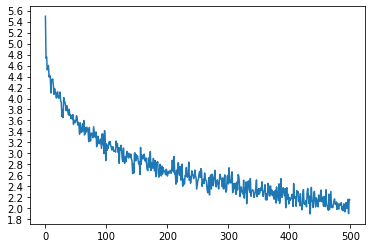

In [22]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2) # put ticks at regular intervals
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

show_plot(plot_losses)

# 模型验证

In [23]:
def evaluate(sentence, max_length=MAX_LENGTH):
    input_variable = variable_from_sentence(input_lang, sentence)
    input_length = input_variable.size()[0]
    
    # Run through encoder
    encoder_hidden = encoder.init_hidden()
    encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)

    # Create starting vectors for decoder
    decoder_input = torch.LongTensor([[SOS_token]]) # SOS
    if USE_CUDA:
        decoder_input = decoder_input.cuda()

    decoder_hidden = encoder_hidden
    
    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)
    
    # Run through decoder
    for di in range(max_length):
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
        # Choose top word from output
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[ni.item()])
            
        # Next input is chosen word
        decoder_input = torch.LongTensor([[ni]])
        if USE_CUDA: decoder_input = decoder_input.cuda()
    
    return decoded_words

随机选取一个句子进行验证。

In [24]:
def evaluate_randomly():
    pair = random.choice(pairs)
    
    output_words = evaluate(pair[0])
    output_sentence = ' '.join(output_words)
    
    print('>', pair[0])
    print('=', pair[1])
    print('<', output_sentence)
    print('')

In [35]:
evaluate_randomly()

> 我喜欢跑步。
= i like running .
< i like run . <EOS>



/home/hotbaby/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/hotbaby/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [26]:
' '.join(evaluate('人生是有趣的。'))

/home/hotbaby/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/hotbaby/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


'life is fun . <EOS>'

随机的验证只是一个简单的例子，为了能系统性的完成测试数据的翻译，这里仍需要实现一个新的函数。

In [27]:
import collections

pairs_dict = collections.defaultdict(lambda : [])

for pair in pairs:
    pairs_dict[pair[0]].append(pair[1].split(' '))

In [28]:
def evaluate_bleu_score(size=100):
    candicates = []
    references = []

    for i, pair in enumerate(pairs_dict.items(), start=1):
        candicate = evaluate(pair[0])
        if candicate[-1] == '<EOS>':
            candicate.pop(-1)
        candicates.append(candicate)
        references.append(pair[1])
        
        if size > 0 and size == i:
            break
    
    score = bleu_score(candicates, references)
    return score

In [29]:
evaluate_bleu_score(100)

/home/hotbaby/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/hotbaby/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


0.39970383048057556